# Differentiable tree message passing with `phylax`

This tutorial demonstrates how to use the `phylax` package to perform message passing on ETE3 trees that is compilable with `jax.jit` and differentiable with `jax.grad`.
See also the `phylax` API docs page.

As a simple example, we will define message and update functions that compute the _local branching index_ (LBI) of Neher et al. (https://elifesciences.org/articles/03568).
The LBI of a tree node is defined as the integral of total tree branch length with a kernel that decays exponentially with distance from the node (with characteristic length scale $\tau$).
This can be computed efficiently for all nodes (without redundant computation of branch integrals) using message passing.

After detailing the upward and downward messages passing steps, we demonstrate how to build a LBI-based predictor that is compatible with `jax.jit` and `jax.grad`, and can be optimized using gradient descent to find the optimal kernel parameter $\tau$ for a given tree node prediction task.

In [1]:
from __future__ import annotations

import phylax.message as msg
from gcdyn import bdms, mutators, poisson

import jax.numpy as jnp
import jax.tree_util as jtu
from jaxtyping import Array, Int, Float
import equinox as eqx
import ete3
import numpy as onp
import matplotlib.pyplot as plt

/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


## Example tree

We'll use the `gcdyn` package to simulate a tree via a birth-death-mutation-sampling (BDMS) process.

First we define necessary objects that determine how birth, death, and mutation rates responds to a phenotype $x$, which undergoes mutations.

In [2]:
birth_rate = poisson.SigmoidResponse(xscale=3.0, xshift=0.4, yscale=4, yshift=0.0)
death_rate = poisson.ConstantResponse(0.8)
mutation_rate = poisson.ConstantResponse(1.1)
mutator = mutators.GaussianMutator(shift=-0.1, scale=0.1)

Plot these simulation parameters as a function of $x$.

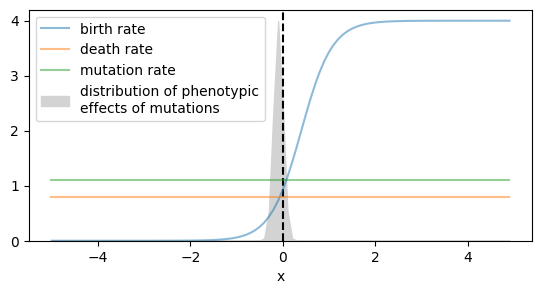

In [3]:
x_grid = onp.arange(-5, 5, 0.1)
plt.figure(figsize=(6.5, 3))
plt.axvline(0, color="k", linestyle="--")
plt.plot(x_grid, birth_rate.λ_phenotype(x_grid), label=f"birth rate", alpha=0.5)
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.plot(x_grid, mutation_rate.λ_phenotype(x_grid), label="mutation rate", alpha=0.5)
plt.fill_between(x_grid, mutator.prob(0, x_grid), color="lightgrey", label="distribution of phenotypic\neffects of mutations")
plt.xlabel('x')
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

Set random seed and simulate a tree starting with a root node having phenotype $x=0$.
We set up a loop that retries the simulation until we get a tree with at least a specified number of survivors at the sampling time.

In [4]:
rng = onp.random.default_rng(seed=0)

max_attempts = 1000
for iter in range(max_attempts):
    try:
        tree = bdms.TreeNode()
        tree.x = 0
        tree.evolve(
            10,
            birth_response=birth_rate,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            capacity=1000,
            birth_mutations=False,
            seed=rng,
        )
        n_tips = len(tree)
        n_survivors = sum(node.event == "survival" for node in tree)
        print(f"attempt {iter + 1} succeeded: {n_tips=}, {n_survivors=}")
        break
    except bdms.TreeError as e:
        if iter == max_attempts - 1:
            raise RuntimeError(f"reached {max_attempts=} without success") from e
        continue

attempt 625 succeeded: n_tips=1281, n_survivors=530


Ladderize and visualize the simulated tree.

In [5]:
tree.ladderize()

1281

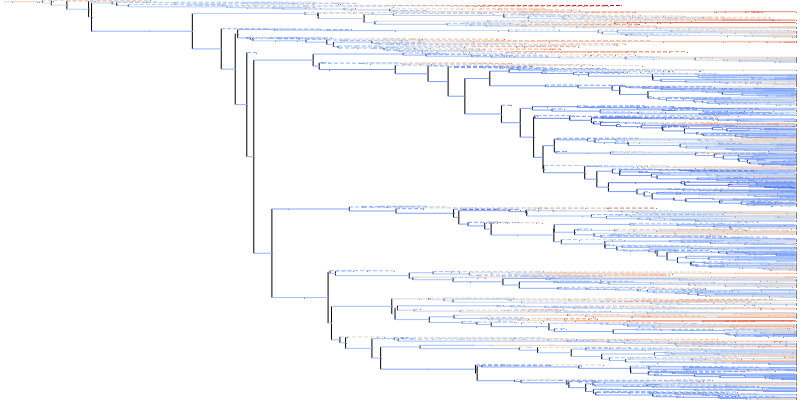

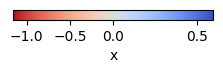

In [6]:
tree.render("x", "%%inline", w=800, h=400)

Sample a fraction of the survivors, and prune to the subtree that subtends these sampled leaves.
We also remove unifurcating mutation event nodes.

In [7]:
tree.sample_survivors(p=0.5, seed=rng)
tree.prune()
tree.remove_mutation_events()
tree.ladderize()

265

Visualize the sampled tree, with nodes colored by phenotype $x$.
Note that this tree is ultrametric, but appears non-ultrametric due to the size of internal nodes.

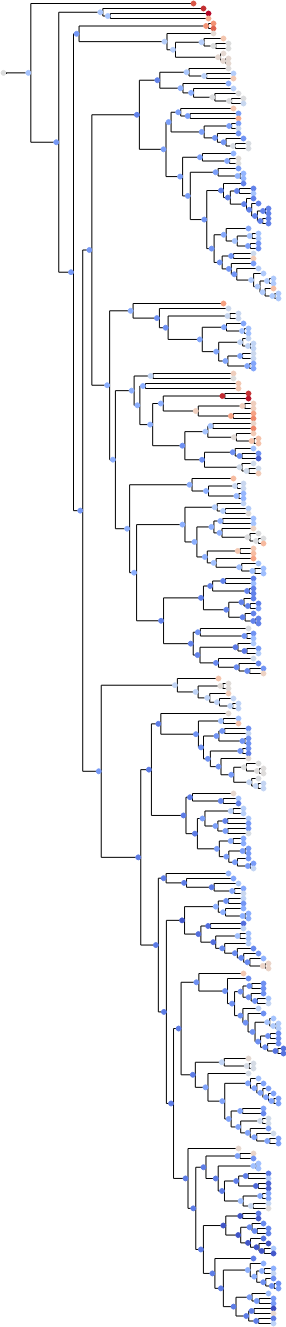

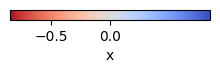

In [8]:
def layout(node):
    node.img_style["size"] = 5

tree.render("x", "%%inline", layout)

Mean phenotype $x$ of the sampled leaves.

In [9]:
onp.median([leaf.x for leaf in tree])

0.15933984420257383

## Message passing to compute LBI

The LBI can be efficiently computed for all nodes of a tree using two message passing passes:
1. A post-order traversal of the tree to compute the integral of the total branch length of the subtree rooted at each node, weighted by an exponential kernel that decays with distance from the node.
2. A pre-order traversal of the tree to compute the LBI of each node as the sum of the integral computed in step 1 and the LBI of its parent node, less the contribution of the focal node to the parent's LBI (to avoid integrating this subtree twice).

### Messengers and updaters

For `phylax.messenger`, we must define messenger and update classes for each of these passes, as subclasses of `phylax.messenger.Messenger` and `phylax.messenger.Updater`, respectively (see more on this `phylax` API docs).

In [10]:
class UpMessengerLBI(msg.Messenger):
    """Computes ``LB_down``, the integral of the tree length that descends the node with an exponential kernel.
    
    Args:
        τ: the exponential kernel scale parameter
    """
    τ: Float
    null_value: Float

    def __init__(self, τ: Float):
        self.τ = τ
        self.null_value = 0.0

    def __call__(self, child_messages: Float[Array, "c 2"], parent_features: Float) -> Float:
        child_branch_lens = child_messages[:, 0]
        child_lb_downs = child_messages[:, 1]
        branch_integrals = self.τ * (1 - jnp.exp(-child_branch_lens / self.τ))
        discount_factors = jnp.exp(-child_branch_lens / self.τ)
        parent_lb_down = (branch_integrals + discount_factors * child_lb_downs).sum(axis=0)
        return parent_lb_down
    
class DownMessengerLBI(msg.Messenger):
    """Computes ``LB_up``, the integral of the tree length that doesn't descend the node with an exponential kernel.

    Args:
        τ: the exponential kernel scale parameter
    """
    τ: Float
    null_value: Float

    def __init__(self, τ: Float):
        self.τ = τ
        self.null_value = 0.0

    def __call__(self, parent_lbis: Float[Array, "p 1"], child_features: Float[Array, " 2"]) -> Float:
        child_branch_len = child_features[0]
        child_lb_down = child_features[1]
        branch_integral = self.τ * (1 - jnp.exp(-child_branch_len / self.τ))
        discount_factor = jnp.exp(-child_branch_len / self.τ)
        child_lb_up = branch_integral + discount_factor * parent_lbis.sum(axis=0)
        # If there is a parent, we have to subtract the duplicated integral for this subtree already stored in its LBI.
        n_parents = (parent_lbis != self.null_value).sum(axis=0)
        child_lb_up -= n_parents * (discount_factor * child_lb_down + branch_integral)
        return child_lb_up

class UpdaterLBI(msg.Updater):
    """Concatenates the node distance and the downward integral."""
    r: Int = 2

    def __call__(self, node_dist: Float, message: Float) -> Float[Array, " 2"]:
        return jnp.hstack([node_dist, message])
    
class DowndaterLBI(msg.Updater):
    """Adds the upward and downward integrals to give the LBI."""
    r: Int = 1

    def __call__(self, node_features: Float[Array, " 2"], message: Float) -> Float:
        return jnp.hstack(node_features[1] + message)

### Tree messege passer

We can now instantiate the core `phylax.messenger.TreeMessagePasser` class using our tree and the above messengers and updaters.

In [11]:
message_passer = msg.TreeMessagePasser(tree,
                                       up_messenger=UpMessengerLBI(τ=1.0),
                                       down_messenger=DownMessengerLBI(τ=1.0),
                                       updater=UpdaterLBI(),
                                       downdater=DowndaterLBI())

Now, the node feature of interest for LBI is the branch length, which is the `dist` attribute of each `ete3` tree node.
We initialize node representations thusly.

In [12]:
representations = message_passer.initialize_features(tree, ("dist",))

representations.shape

(530, 1)

### Upward (post-order) pass

Perform the upward pass, giving updated representations with two columns: the previous branch length features (which are still needed for the upcoming downward pass), and the accumulated subtree integrals.
Note that the `phylax.messenger.TreeMessagePasser.upward()` method returns the output node representations, as well as the full trajectory of node representations at each step of the post-order traversal.

In [13]:
representations, representations_trajectory = message_passer.upward(representations)

representations.shape

(530, 2)

As a sanity check assert that final element of the representations trajectory should equal the output representations.

In [14]:
assert jnp.all(representations == representations_trajectory[-1])

We can add the subtree integrals to the ETE3 tree as node attributes, and then visualize the tree with nodes colored according to these integrals.

In [15]:
message_passer.decorate(representations[:, 1].squeeze(), tree, "LB_down")

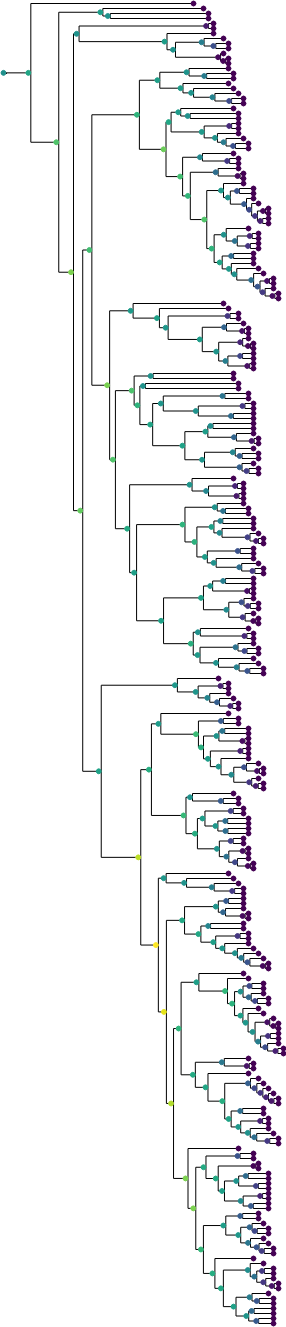

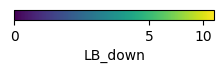

In [16]:
def layout(node):
    node.img_style["size"] = 5

tree.render("LB_down", "%%inline", layout, cmap="viridis")

As another sanity check, the subtree integrals of the leaf nodes should be zero because they have no descendant branches, and the non-leaves almost surely have nonzero integrals.

In [17]:
for node in tree.traverse():
    if node.is_leaf():
        assert node.LB_down == 0
    else:
        assert node.LB_down > 0

### Downward (pre-order) pass

Perform the downward pass, giving a final representation as the LBI of each node.
Analogous to the upward pass, the `phylax.messenger.TreeMessagePasser.downward()` method returns the output node representations, as well as the full trajectory of node representations at each step of the pre-order traversal.

In [18]:
representations, representations_trajectory = message_passer.downward(representations)

We again assert that final element of the representations trajectory should equal the output representations.

In [19]:
assert jnp.all(representations == representations_trajectory[-1])

Add LBI to the ETE3 tree as node attributes, and then visualize the tree with nodes colored according to LBI.

In [20]:
message_passer.decorate(representations.squeeze(), tree, "LBI")

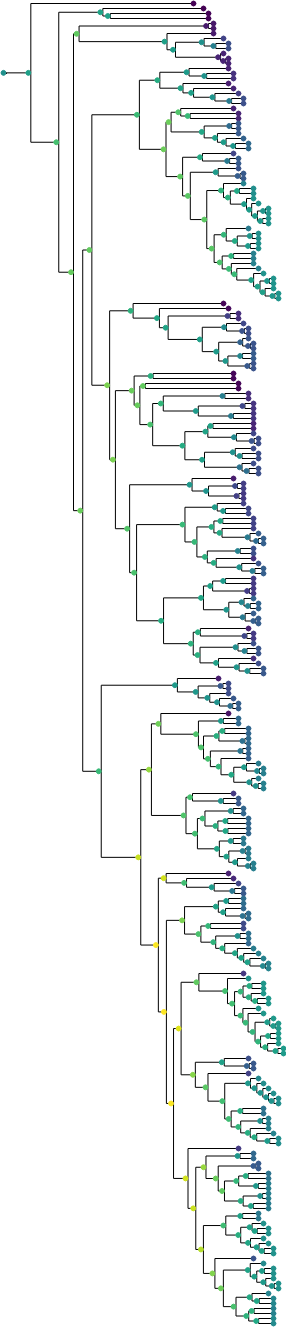

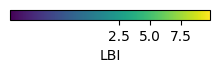

In [21]:
def layout(node):
    node.img_style["size"] = 5

tree.render("LBI", "%%inline", layout, cmap="viridis")

To validate that representations satisfy graph isomorphism, we check that sister leaf nodes have the same LBI.

In [22]:
def is_cherry(node):
    return not node.is_leaf() and len(node.children) > 1 and all(child.is_leaf() for child in node.children)

n_cherries = 0
for cherry in tree.iter_leaves(is_cherry):
    sister_lbis = jnp.array([sister.LBI for sister in cherry.children])
    assert jnp.allclose(*sister_lbis), sister_lbis
    n_cherries += 1
print(f"{n_cherries} cherries validated")

92 cherries validated


As long as the root node has no branch above it, the LBI of the root node should equal the tree integral from the upward pass (i.e. it is not modified by the downward pass).

In [23]:
assert tree.dist == 0 and tree.LB_down == tree.LBI

## A toy model using LBI for a node prediction task

To demonstate how to use `phylax.messenger.TreeMessagePasser` as a layer in a node prediction model,
we'll build a toy model that predicts the phenotype $x$ of a node from its LBI.
Our predictor for node $v\in\mathcal{V}$ is

$$
\hat x_v(\alpha,\beta,\tau) = \alpha \log\text{LBI}_\tau(v) + \beta,
$$
    
where $\alpha$, $\beta$, and $\tau$ are learnable parameters.
We minimize a loss function that is additive over the node-wise predictions.

$$
\hat\alpha,\hat\beta,\hat\tau = \argmin_{\alpha,\beta,\tau}\sum_{v\in \mathcal{V}}\ell\left(x_v,\hat x_v(\alpha,\beta,\tau)\right),
$$

In [24]:
class LBImodel(eqx.Module):
    r"""A model that uses the log-LBI as a linear tree node feature predictor.

    Args:
        tree: the tree to do prediction on
        τ: the LBI exponential kernel scale parameter
        α: the linear predictor coefficient
        β: the linear predictor intercept
    """
    message_passer: msg.TreeMessagePasser
    α: Float
    β: Float
    def __init__(self, tree: ete3.Tree, τ: Float = 1.0, α: Float = 1.0, β: Float = 0.0) -> None:
        self.message_passer = msg.TreeMessagePasser(tree,
                                                    up_messenger=UpMessengerLBI(τ=τ),
                                                    down_messenger=DownMessengerLBI(τ=τ),
                                                    updater=UpdaterLBI(),
                                                    downdater=DowndaterLBI())
        self.α = α
        self.β = β
        # NOTE: this filter indicates self's trainable parameters as a convenience for optimization

    @eqx.filter_jit
    def __call__(self) -> Float[Array, " n"]:
        out = self.message_passer.branch_lengths[:, None]
        out, _ = self.message_passer.upward(out)
        out, _ = self.message_passer.downward(out)
        return self.α * jnp.log(out.squeeze()) + self.β

    @property
    def τ(self) -> Float:
        """The LBI exponential kernel scale parameter"""
        if self.message_passer.up_messenger.τ != self.message_passer.down_messenger.τ:
            raise RuntimeError("Up and down messenger τ values are not equal")
        return self.message_passer.up_messenger.τ
    
    @staticmethod
    def trainable(model: LBImodel):
        """Returns the trainable parameters of the model."""
        return model.message_passer.up_messenger.τ, model.message_passer.down_messenger.τ, model.α, model.β

    def filter_trainable(self) -> LBImodel:
        """Returns a pytree indicator filter, the same shape as self, that picks out the trainable parameters.
        We'll need this for gradient updates on these model attributes only.
        """
        return eqx.tree_at(self.trainable, jtu.tree_map(lambda node: False, self), replace=(True, True, True, True))

### Loss function and projected gradient step

In [25]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_grad(diff_model, static_model, x):
    model = eqx.combine(diff_model, static_model)
    pred_x = model()
    residuals = jnp.abs(x - pred_x)
    # Huber loss
    δ = 0.5
    return jnp.where(residuals < δ, 0.5 * residuals ** 2, δ * residuals - 0.5 * δ ** 2).mean()

@eqx.filter_jit
def step(model, filter, x, γ=0.001):    
    diff_model, static_model = eqx.partition(model, filter)
    loss, grad = loss_grad(diff_model, static_model, x)
    # gradient step
    updates = eqx.tree_at(model.trainable, grad, replace_fn=lambda param: - γ * param)
    model = eqx.apply_updates(model, updates)
    # orthogonal projection to constrain equal τ in both the up and down messengers, and non-negative
    τ_projected_xy = jnp.clip((model.message_passer.up_messenger.τ + model.message_passer.down_messenger.τ) / 2, 0, None)
    model = eqx.tree_at(lambda model: (model.message_passer.up_messenger.τ, model.message_passer.down_messenger.τ),
                        model, replace=(τ_projected_xy, τ_projected_xy)) 

    return model, loss

### Fit model to node phenotypes

Initialize LBI model

In [26]:
params = jnp.array([1.0, 1.0, 0.0])  # need to make these jax.Array scalars for Equinox filtered jits and grads to work
model = LBImodel(tree, *params)
filter = model.filter_trainable()

Extract prediction target (phenotype $x$) from the tree.
We can use the `phylax.messenger.TreeMessagePasser.initialize_features()` to extract these in the correct order.

In [27]:
x = model.message_passer.initialize_features(tree, ("x",)).squeeze()

Iterate model, keeping tracking the loss trajectory over iterates.

In [28]:
n_iter = 1000
loss_trajectory = onp.zeros(n_iter)
for iter in range(n_iter):
    model, loss = step(model, filter, x, γ=0.01)
    loss_trajectory[iter] = loss

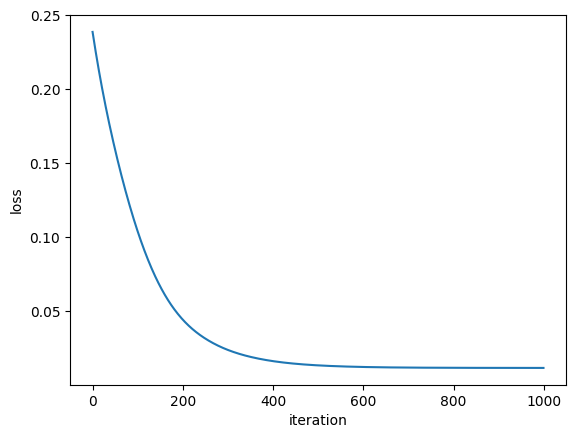

In [29]:
plt.plot(loss_trajectory)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

Plot predictions.

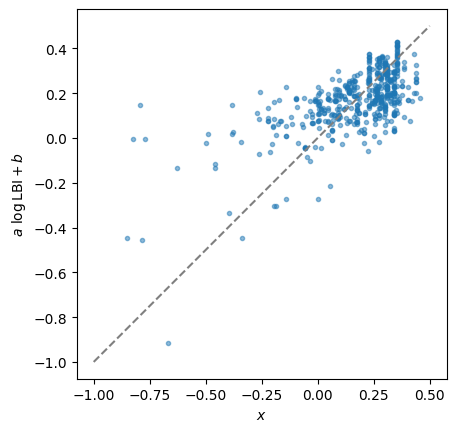

In [30]:
pred_x = model()
plt.plot(x, pred_x, ".", alpha=0.5)
plt.plot([-1, 0.5], [-1, 0.5], "--", color="gray")
plt.xlabel("$x$")
plt.ylabel("$a \ \log \mathrm{LBI} + b$")
plt.axis('square')
plt.show()

In [31]:
(model.τ, model.α, model.β)

(Array(1.10343042, dtype=float64),
 Array(0.14480497, dtype=float64),
 Array(0.0737401, dtype=float64))